Все вычисления выполнены на Intel Core i7-12650H (2.30 ГГц) с 10 ядрами

In [136]:
%%bash
gcc main.c -o main.so -fopenmp -lm -O3 -shared -fPIC

In [137]:
import numpy as np
import matplotlib.pyplot as plt

In [138]:
NUMBER_OF_EXPEREMENTS = 10
MAX_BLOCK_SIZE = 40
BLOCK_STEP = 1
MAX_NET_SIZE = 2000
NET_STEP = 200
ERROR = 0.01

In [139]:
def get_experiment_result(thread_count, approximate_error, block_size, net_size, function_number=1):
    from ctypes import CDLL, Structure, c_size_t, c_double
    main = CDLL("./main.so")
    class exec_res_t(Structure):
        _fields_ = [
            ("number_of_iterations", c_size_t),
            ("total_time", c_double)
        ]
    main.execute.restype = exec_res_t
    res = main.execute(c_size_t(thread_count), c_double(approximate_error), c_size_t(block_size), c_size_t(net_size), function_number)
    return (res.number_of_iterations, res.total_time)

Оценим как влияет размер блока на количество итераций и время выполнения.

Для этого переберем все размеры блока до MAX_BLOCK_SIZE с шагом BLOCK_STEP.

In [140]:
def calculate_mean_per_block_size(cpu_count):
  result_time = [[] for _ in range(0, MAX_BLOCK_SIZE, BLOCK_STEP)]
  result_iter = [[] for _ in range(0, MAX_BLOCK_SIZE, BLOCK_STEP)]

  for i in range(len(result_time)):
    for _ in range(NUMBER_OF_EXPEREMENTS):
        iter, time = get_experiment_result(cpu_count, ERROR, i * BLOCK_STEP + 1, 25)
        result_time[i].append(time)
        result_iter[i].append(iter)
        # print(i)

  for i in range(len(result_time)):
    result_time[i] = np.mean(result_time[i])
    result_iter[i] = np.mean(result_iter[i])
  return result_time, result_iter

In [141]:
def calculate_mean_per_net_size(cpu_count):
  result_time = [[] for _ in range(0, MAX_NET_SIZE, NET_STEP)]
  result_iter = [[] for _ in range(0, MAX_NET_SIZE, NET_STEP)]

  for i in range(len(result_time)):
    for _ in range(NUMBER_OF_EXPEREMENTS):
        iter, time = get_experiment_result(cpu_count, ERROR, 40, i * NET_STEP + NET_STEP)
        result_time[i].append(time)
        result_iter[i].append(iter)

  for i in range(len(result_time)):
    result_time[i] = np.mean(result_time[i])
    result_iter[i] = np.mean(result_iter[i])
  return result_time, result_iter

In [142]:
x_coords_block = [i * BLOCK_STEP + 1 for i in range(0, MAX_BLOCK_SIZE, BLOCK_STEP)]
y1_time_block, y1_iter_block  = calculate_mean_per_block_size(1)
y8_time_block, y8_iter_block  = calculate_mean_per_block_size(8)

x_coords_net = [i for i in range(NET_STEP, MAX_NET_SIZE + NET_STEP, NET_STEP)]
y1_time_net, y1_iter_net  = calculate_mean_per_net_size(1)
y2_time_net, y2_iter_net  = calculate_mean_per_net_size(2)
y4_time_net, y4_iter_net  = calculate_mean_per_net_size(4)
y8_time_net, y8_iter_net  = calculate_mean_per_net_size(8)

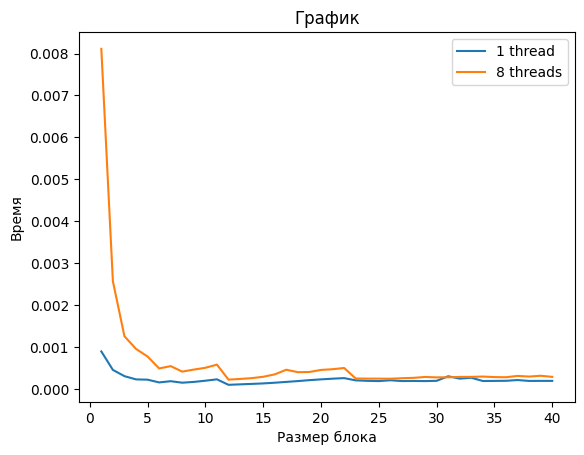

In [143]:
plt.title('График')
plt.xlabel('Размер блока')
plt.ylabel('Время')
plt.plot(x_coords_block, y1_time_block, label="1 thread")
plt.plot(x_coords_block, y8_time_block, label="8 threads")
plt.legend()
plt.show()

Как видно из графика выше, BLOCK_SIZE <= 5 замедляет время выполнения до восьми раз для восьми потоков.

Затем время выполнение асцилирует, пока не нормализируется, так как BLOCK_SIZE превосходит размер сетки и все вычисление происходит единым блоком.

Так же видно, что алгоритм для восьми потоков работает медленее, чем для одного. Это обусловлено высокими расходами на синхронизацию для небольшого размера сетки.

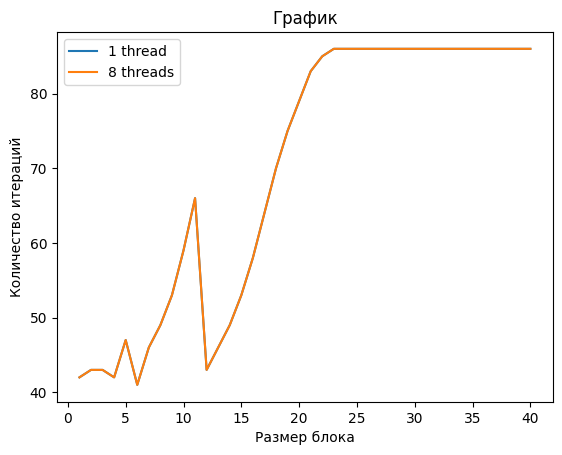

In [144]:
plt.title('График')
plt.xlabel('Размер блока')
plt.ylabel('Количество итераций')
plt.plot(x_coords_block, y1_iter_block, label="1 thread")
plt.plot(x_coords_block, y8_iter_block, label="8 threads")
plt.legend()
plt.show()

Гипотезу выше подтверждает этот график, так как количество итераций начиная с BLOCK_SIZE=25 одинаково.

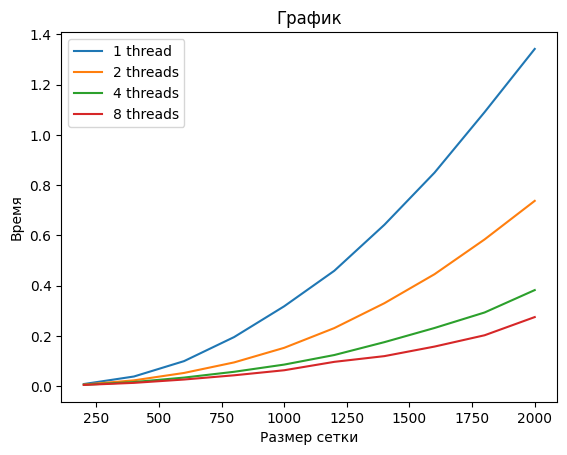

In [145]:
plt.title('График')
plt.xlabel('Размер сетки')
plt.ylabel('Время')
plt.plot(x_coords_net, y1_time_net, label="1 thread")
plt.plot(x_coords_net, y2_time_net, label="2 threads")
plt.plot(x_coords_net, y4_time_net, label="4 threads")
plt.plot(x_coords_net, y8_time_net, label="8 threads")
plt.legend()
plt.show()

На графике можно увидеть как меняется скорость вычисления в зависимости от количества потоков и увеличения размера сетки. Так, для размера сетки 2000, время выполнения для восьми потоков в шесть раз меньше, чем для одного потока.